In [ ]:
import os
from dateutil.parser import parse
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
teste

In [3]:
emcm_path = r'C:\Users\Sylvia\OneDrive\Documentos\Faculdade\Projeto_Pesquisa\Projeto_2\Dados\campo_03042025\correntografos\\'
emcm_files = os.listdir(emcm_path)

In [4]:
for i, f in enumerate(emcm_files):
    print(i, f, os.path.getsize(emcm_path + f))

0 20250403_0900_AEM-USB_0824_132518_A.csv 830614
1 20250403_0900_AEM-USB_0825_132212_A.csv 808573
2 20250403_0900_AEM-USB_0826_131909_A.csv 846680
3 Nova pasta 4096


In [5]:
with open(emcm_path + emcm_files[0]) as io:
    emcm_0824_lines = io.readlines()

with open(emcm_path + emcm_files[1]) as io:
    emcm_0825_lines = io.readlines()

with open(emcm_path + emcm_files[2]) as io:
    emcm_0826_lines = io.readlines()

hdr = emcm_0824_lines[31].split(',')

for i, h in enumerate(hdr):
    print(i, h)

0 Date
1 Vel.[cm/sec]
2 Dir[deg]
3 Vel. -NS[cm/sec]
4 Vel. -EW[cm/sec]
5 Temp.[deg C]
6 CompA[ ]
7 CompB[ ]
8 Compass[deg]
9 Vel. -X[cm/sec]
10 Vel. -Y[cm/sec]
11 Batt.[V]
12 



In [6]:
# to get the data from the uploaded files
def emcm_get_data(lines):
    emcm_data = []
    for i, li in enumerate(lines[392:]):
        if 'Error' in li:
            continue
    
        liq = li.split(',')
    
        time = parse(liq[0]) #1° coluna em datatime
        floats = [float(x) for x in liq[3:6]] #coluna de 3 a 6
    
        emcm_data.append(np.array([[time] + floats]))
    
    emcm_data = np.array(emcm_data).squeeze()
    return emcm_data


# to reduce the data averaging the bursts
def emcm_data_reduction(data, burstlength):
    # Garante que o número de linhas seja múltiplo de burstlength
    n_rows = (len(data) // burstlength) * burstlength
    data = data[:n_rows]

    # get the first time of each burst
    # tempo = primeiro registro de cada burst
    d_rdz = np.reshape(data[:,0], (-1, burstlength))
    d_rdz = d_rdz[:,0]

    # average the bursts
    # médias por burst para cada variável numérica
    for i in range(1, data.shape[1]):
        d = np.reshape(data[:,i], (-1, burstlength))
        dm = np.mean(d, axis=1)
        d_rdz = np.vstack((d_rdz, dm))

    return d_rdz.T

In [7]:
emcm_0824_data = emcm_get_data(emcm_0824_lines)
emcm_0825_data = emcm_get_data(emcm_0825_lines)
emcm_0826_data = emcm_get_data(emcm_0826_lines)

emcm_0824_rdz = emcm_data_reduction(emcm_0824_data, 60)
emcm_0825_rdz = emcm_data_reduction(emcm_0825_data, 60)
emcm_0826_rdz = emcm_data_reduction(emcm_0826_data, 60)

In [8]:
def filter_time_range(data, start=(10,40), end=(17,0)):
    return data[np.array([dt.time(*start) <= d.time() < dt.time(*end) for d in data[:,0]])]

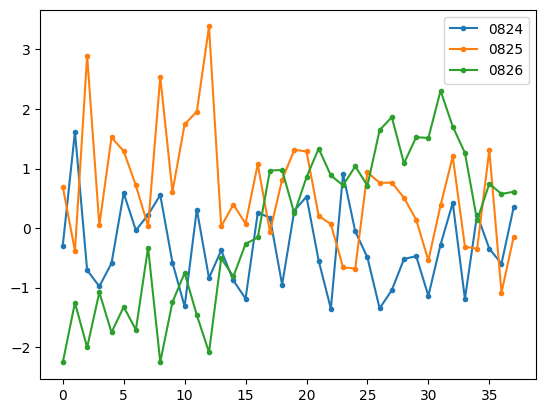

In [9]:
# separating the period in water!
emcm_0824_rdz2 = emcm_0824_rdz[3:-16,:]
emcm_0825_rdz2 = emcm_0825_rdz[3:-16,:]
emcm_0826_rdz2 = emcm_0826_rdz[3:-16,:]

emcm_0824_rdz2 = filter_time_range(emcm_0824_rdz2)
emcm_0825_rdz2 = filter_time_range(emcm_0825_rdz2)
emcm_0826_rdz2 = filter_time_range(emcm_0826_rdz2)

plt.plot(emcm_0824_rdz2[:,1], '.-', label='0824')
plt.plot(emcm_0825_rdz2[:,1], '.-', label='0825')
plt.plot(emcm_0826_rdz2[:,1], '.-', label='0826')
plt.legend()
plt.show()

In [10]:
def vector_rotation(u, v, angle_deg):
    angle_rad = np.deg2rad(angle_deg)
    u_rot = u * np.cos(angle_rad) - v * np.sin(angle_rad)
    v_rot = u * np.sin(angle_rad) + v * np.cos(angle_rad)
    return u_rot, v_rot

In [11]:
u_0824, v_0824 = vector_rotation(emcm_0824_rdz2[:,1], emcm_0824_rdz2[:,2], -16)
u_0825, v_0825 = vector_rotation(emcm_0825_rdz2[:,1], emcm_0825_rdz2[:,2], -16)
u_0826, v_0826 = vector_rotation(emcm_0826_rdz2[:,1], emcm_0826_rdz2[:,2], -16)

In [11]:
# # cm/s -> m/s
# u_0824 = u_0824 / 100
# u_0825 = u_0825 / 100
# u_0826 = u_0826 / 100

# v_0824 = v_0824 / 100
# v_0825 = v_0825 / 100
# v_0826 = v_0826 / 100


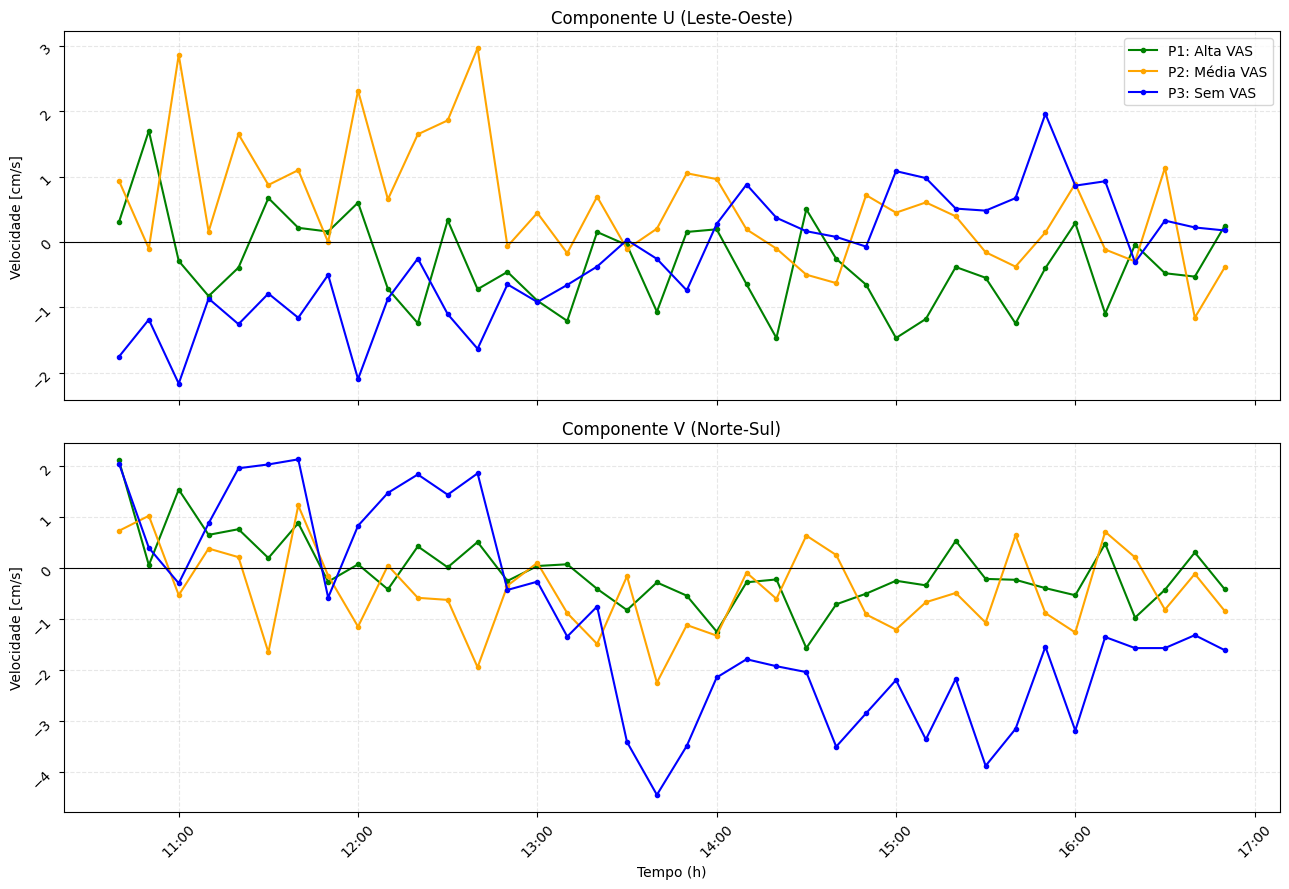

In [12]:
import matplotlib.dates as mdates

cores = ['green', 'orange', 'blue']
labels = ['P1: Alta VAS', 'P2: Média VAS', 'P3: Sem VAS']

fig, axs = plt.subplots(2, 1, figsize=(13,9), sharex=True)

# Componente U (leste-oeste)
axs[0].plot(emcm_0824_rdz2[:,0], u_0824, '.-', color=cores[0], label=labels[0])
axs[0].plot(emcm_0825_rdz2[:,0], u_0825, '.-', color=cores[1], label=labels[1])
axs[0].plot(emcm_0826_rdz2[:,0], u_0826, '.-', color=cores[2], label=labels[2])
axs[0].axhline(0, color='k', linewidth=0.8)
axs[0].set_title('Componente U (Leste-Oeste)')
axs[0].set_ylabel('Velocidade [cm/s]')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.3)

# Componente V (norte-sul)
axs[1].plot(emcm_0824_rdz2[:,0], v_0824, '.-', color=cores[0])
axs[1].plot(emcm_0825_rdz2[:,0], v_0825, '.-', color=cores[1])
axs[1].plot(emcm_0826_rdz2[:,0], v_0826, '.-', color=cores[2])
axs[1].axhline(0, color='k', linewidth=0.8)
axs[1].set_title('Componente V (Norte-Sul)')
axs[1].set_ylabel('Velocidade [cm/s]')
axs[1].grid(True, linestyle='--', alpha=0.3)

for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1)) 
    ax.tick_params(rotation=45)
axs[1].set_xlabel('Tempo (h)')

plt.tight_layout()
plt.savefig('Correntografo_2Camp.png', dpi=700, bbox_inches='tight')
plt.show()

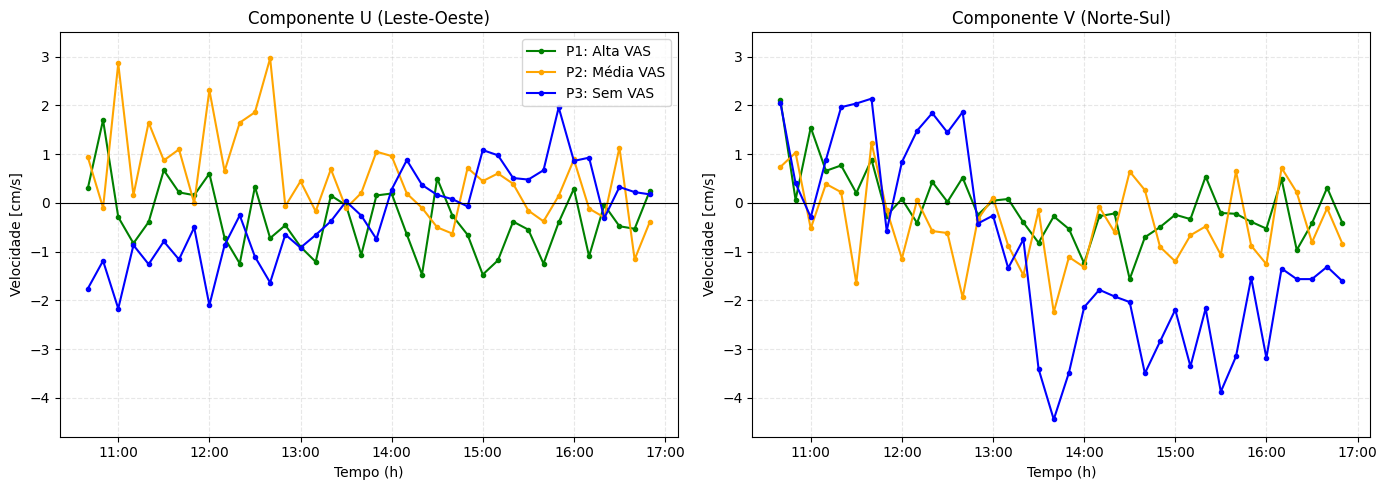

In [13]:
cores = ['green', 'orange', 'blue']
labels = ['P1: Alta VAS', 'P2: Média VAS', 'P3: Sem VAS']

fig, axs = plt.subplots(1, 2, figsize=(14,5), sharex=True)

# Componente U (leste-oeste)
axs[0].plot(emcm_0824_rdz2[:,0], u_0824, '.-', color=cores[0], label=labels[0])
axs[0].plot(emcm_0825_rdz2[:,0], u_0825, '.-', color=cores[1], label=labels[1])
axs[0].plot(emcm_0826_rdz2[:,0], u_0826, '.-', color=cores[2], label=labels[2])
axs[0].axhline(0, color='k', linewidth=0.8)
axs[0].set_title('Componente U (Leste-Oeste)')
axs[0].set_ylabel('Velocidade [cm/s]')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.3)

# Componente V (norte-sul)
axs[1].plot(emcm_0824_rdz2[:,0], v_0824, '.-', color=cores[0])
axs[1].plot(emcm_0825_rdz2[:,0], v_0825, '.-', color=cores[1])
axs[1].plot(emcm_0826_rdz2[:,0], v_0826, '.-', color=cores[2])
axs[1].axhline(0, color='k', linewidth=0.8)
axs[1].set_title('Componente V (Norte-Sul)')
axs[1].set_ylabel('Velocidade [cm/s]')
axs[1].grid(True, linestyle='--', alpha=0.3)

for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1)) 
    ax.set_xlabel('Tempo (h)')
    ax.set_ylim(-4.8,3.5)

plt.tight_layout()
plt.savefig('Dados_Vel_Cor.png', dpi=700, bbox_inches='tight')
plt.show()

In [14]:
# def cart2polar(u, v):
#     """
#     Converte componentes cartesianas u (leste) e v (norte)
#     para módulo da velocidade e direção em graus (0°=N, CW).
#     """
#     vel = np.sqrt(u**2 + v**2)
#     # ângulo matemático (0° = eixo x positivo, CCW)
#     theta_math = np.degrees(np.arctan2(v, u))
#     # converter para direção de bússola (0°=N, sentido horário)
#     dir_deg = (90 - theta_math) % 360
#     return vel, dir_deg

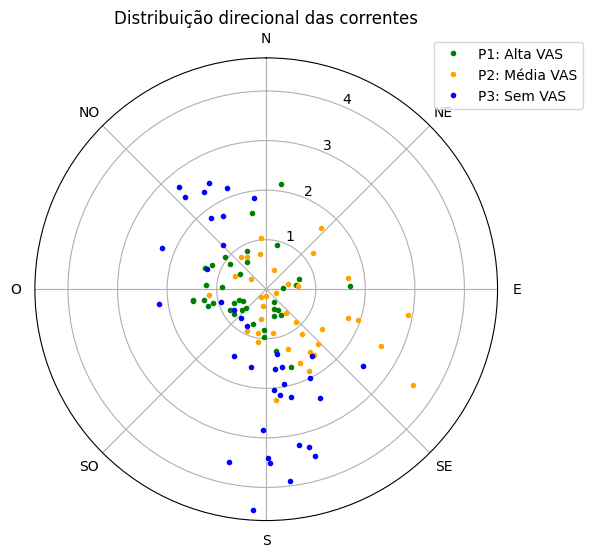

In [15]:
def cart2polar(u, v):
    vel = np.sqrt(u**2 + v**2)
    theta_math = np.degrees(np.arctan2(v, u))
    dir_deg = (90 - theta_math) % 360
    return vel, dir_deg

# Converter para float64
u_0824 = np.array(u_0824, dtype=float)
v_0824 = np.array(v_0824, dtype=float)
u_0825 = np.array(u_0825, dtype=float)
v_0825 = np.array(v_0825, dtype=float)
u_0826 = np.array(u_0826, dtype=float)
v_0826 = np.array(v_0826, dtype=float)

# Calcular módulo e direção
vel_0824, dir_0824 = cart2polar(u_0824, v_0824)
vel_0825, dir_0825 = cart2polar(u_0825, v_0825)
vel_0826, dir_0826 = cart2polar(u_0826, v_0826)

labels = ['N', 'NE', 'E', 'SE', 'S', 'SO', 'O', 'NO']
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection':'polar'})

ax.set_theta_zero_location("N")   # 0° no topo
ax.set_theta_direction(-1)        # sentido horário
ax.set_xticks(np.deg2rad([0,45,90,135,180,225,270,315]))
ax.set_xticklabels(labels)

ax.plot(np.deg2rad(dir_0824), vel_0824, '.', color='green', label='P1: Alta VAS')
ax.plot(np.deg2rad(dir_0825), vel_0825, '.', color='orange', label='P2: Média VAS')
ax.plot(np.deg2rad(dir_0826), vel_0826, '.', color='blue', label='P3: Sem VAS')

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05))
ax.set_title('Distribuição direcional das correntes')

plt.tight_layout()
plt.show()


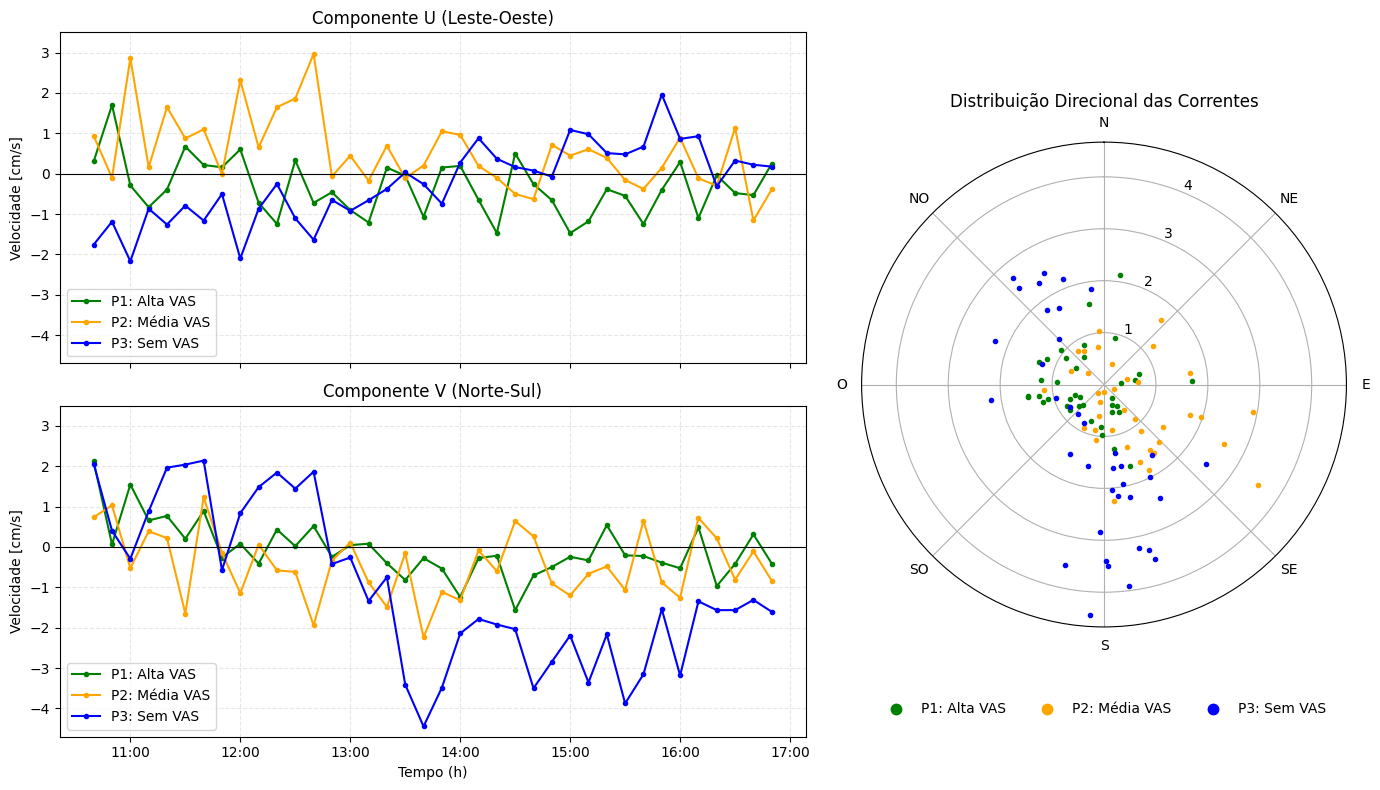

In [18]:
# --- Configuração do layout (2x2 com GridSpec) ---
fig = plt.figure(figsize=(14,8))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1.3])

cores = ['green', 'orange', 'blue']
labels = ['P1: Alta VAS', 'P2: Média VAS', 'P3: Sem VAS']

# Componente U
ax_u = fig.add_subplot(gs[0,0])
ax_u.plot(emcm_0824_rdz2[:,0], u_0824, '.-', color=cores[0], label=labels[0])
ax_u.plot(emcm_0825_rdz2[:,0], u_0825, '.-', color=cores[1], label=labels[1])
ax_u.plot(emcm_0826_rdz2[:,0], u_0826, '.-', color=cores[2], label=labels[2])
ax_u.axhline(0, color='k', linewidth=0.8)
ax_u.set_title('Componente U (Leste-Oeste)')
ax_u.set_ylabel('Velocidade [cm/s]')
ax_u.legend()
ax_u.grid(True, linestyle='--', alpha=0.3)
ax_u.set_ylim(-4.7, 3.5)

ax_u.set_xlabel('')
ax_u.tick_params(labelbottom=False)

# Componente V
ax_v = fig.add_subplot(gs[1,0], sharex=ax_u)
ax_v.plot(emcm_0824_rdz2[:,0], v_0824, '.-', color=cores[0], label=labels[0])
ax_v.plot(emcm_0825_rdz2[:,0], v_0825, '.-', color=cores[1], label=labels[1])
ax_v.plot(emcm_0826_rdz2[:,0], v_0826, '.-', color=cores[2], label=labels[2])
ax_v.axhline(0, color='k', linewidth=0.8)
ax_v.set_title('Componente V (Norte-Sul)')
ax_v.set_ylabel('Velocidade [cm/s]')
ax_v.legend()
ax_v.legend(loc="lower left")
ax_v.grid(True, linestyle='--', alpha=0.3)
ax_v.set_ylim(-4.7, 3.5)
ax_v.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax_v.xaxis.set_major_locator(mdates.HourLocator(interval=1)) 
ax_v.set_xlabel('Tempo (h)')

# Gráfico Polar
ax_polar = fig.add_subplot(gs[:,1], projection='polar')
ax_polar.set_theta_zero_location("N")
ax_polar.set_theta_direction(-1)
ax_polar.set_xticks(np.deg2rad([0,45,90,135,180,225,270,315]))
ax_polar.set_xticklabels(['N','NE','E','SE','S','SO','O','NO'])
ax_polar.plot(np.deg2rad(dir_0824), vel_0824, '.', color=cores[0], label=labels[0])
ax_polar.plot(np.deg2rad(dir_0825), vel_0825, '.', color=cores[1], label=labels[1])
ax_polar.plot(np.deg2rad(dir_0826), vel_0826, '.', color=cores[2], label=labels[2])
ax_polar.set_title('Distribuição Direcional das Correntes')

ax_polar.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.13),  # move para baixo
    ncol=3,                       # coloca lado a lado
    frameon=False,
    markerscale=2.5
)

plt.tight_layout()
plt.savefig('Correntes_Direcao.png', dpi=700, bbox_inches='tight')
plt.show()

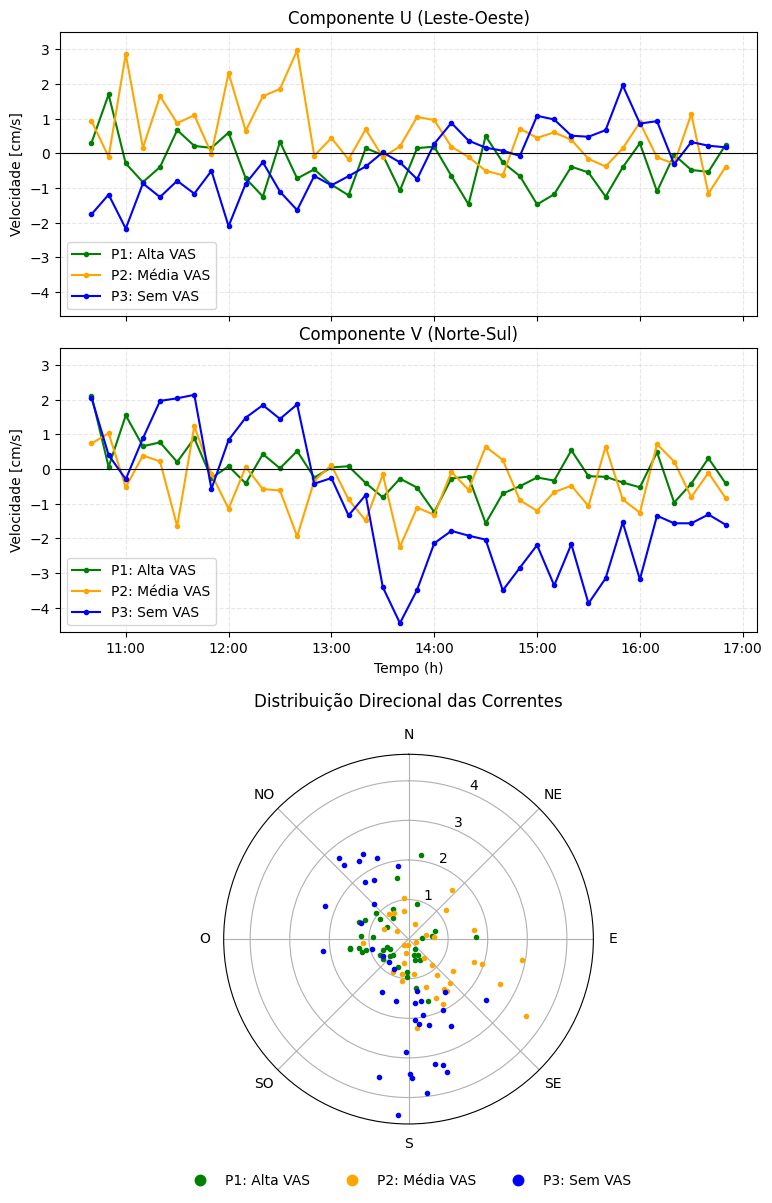

In [76]:
fig = plt.figure(figsize=(9, 13))
#gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1.3])
gs = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1.3], hspace=0.1)

cores = ['green', 'orange', 'blue']
labels = ['P1: Alta VAS', 'P2: Média VAS', 'P3: Sem VAS']

# Componente U 
ax_u = fig.add_subplot(gs[0, 0])
ax_u.plot(emcm_0824_rdz2[:,0], u_0824, '.-', color=cores[0], label=labels[0])
ax_u.plot(emcm_0825_rdz2[:,0], u_0825, '.-', color=cores[1], label=labels[1])
ax_u.plot(emcm_0826_rdz2[:,0], u_0826, '.-', color=cores[2], label=labels[2])
ax_u.axhline(0, color='k', linewidth=0.8)
ax_u.set_title('Componente U (Leste-Oeste)')
ax_u.set_ylabel('Velocidade [cm/s]')
ax_u.legend(loc="lower left")
ax_u.grid(True, linestyle='--', alpha=0.3)
ax_u.set_ylim(-4.7, 3.5)
ax_u.tick_params(labelbottom=False)

# Componente V
ax_v = fig.add_subplot(gs[1, 0], sharex=ax_u)
ax_v.plot(emcm_0824_rdz2[:,0], v_0824, '.-', color=cores[0], label=labels[0])
ax_v.plot(emcm_0825_rdz2[:,0], v_0825, '.-', color=cores[1], label=labels[1])
ax_v.plot(emcm_0826_rdz2[:,0], v_0826, '.-', color=cores[2], label=labels[2])
ax_v.axhline(0, color='k', linewidth=0.8)
ax_v.set_title('Componente V (Norte-Sul)')
ax_v.set_ylabel('Velocidade [cm/s]')
ax_v.legend(loc="lower left")
ax_v.grid(True, linestyle='--', alpha=0.3)
ax_v.set_ylim(-4.7, 3.5)
ax_v.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax_v.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax_v.set_xlabel('Tempo (h)')

# Gráfico Polar
ax_polar = fig.add_subplot(gs[2, 0], projection='polar')
ax_polar.set_theta_zero_location("N")
ax_polar.set_theta_direction(-1)
ax_polar.set_xticks(np.deg2rad([0,45,90,135,180,225,270,315]))
ax_polar.set_xticklabels(['N','NE','E','SE','S','SO','O','NO'])
ax_polar.plot(np.deg2rad(dir_0824), vel_0824, '.', color=cores[0], label=labels[0])
ax_polar.plot(np.deg2rad(dir_0825), vel_0825, '.', color=cores[1], label=labels[1])
ax_polar.plot(np.deg2rad(dir_0826), vel_0826, '.', color=cores[2], label=labels[2])
ax_polar.set_title('Distribuição Direcional das Correntes', pad=15)
pos = ax_polar.get_position()
ax_polar.set_position([pos.x0, pos.y0 - 0.07, pos.width, pos.height])

ax_polar.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=False,
    markerscale=2.5
)

plt.savefig('Correntes_Direcao_AjusteEspaco.png', dpi=700, bbox_inches='tight')
plt.show()

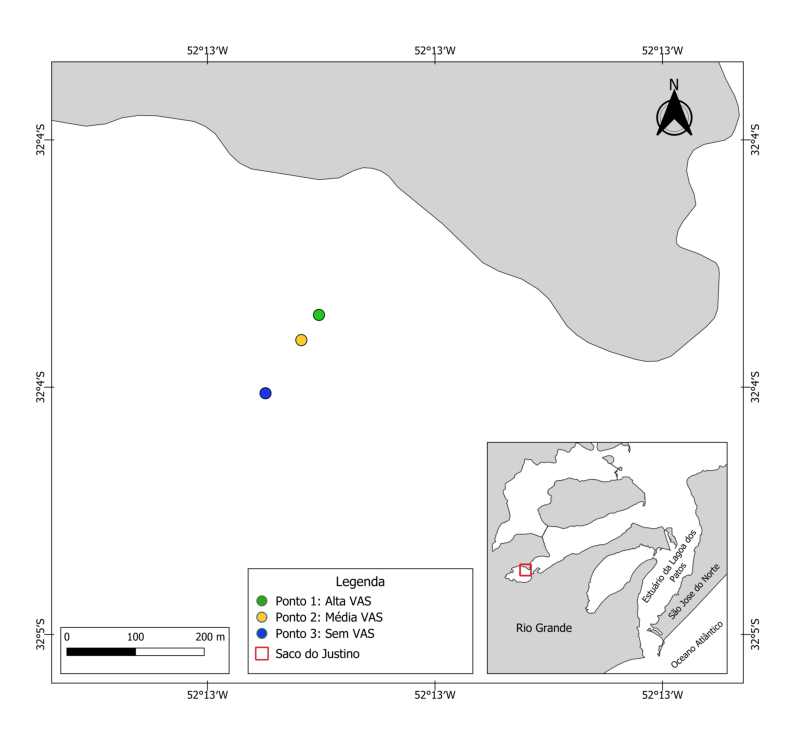

In [3]:
import matplotlib.image as mpimg

img = mpimg.imread(r"C:\Users\Sylvia\OneDrive\Documentos\Faculdade\Projeto_Pesquisa\Projeto_2\Qgis\map.png")

plt.figure(figsize=(10, 10))  # aumenta a figura (largura, altura em polegadas)
plt.imshow(img)
plt.axis('off')
plt.show()